In [3]:
import numpy as np
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.cuda
import time
import math
import torch as t
from numpy import cos,sin,pi,sqrt
import fun_ctions
from scipy.spatial.transform import Rotation as R
from MOT_Classes import Environment,Rubidium,particles,forward
from tqdm import tqdm
import MOT_vars as vr

In [15]:
particles.create(T=1)

(array([[510., 492., 508., 500., 506., 504., 520., 484., 497., 479.],
        [471., 487., 517., 554., 480., 522., 485., 495., 485., 504.],
        [501., 535., 509., 466., 471., 510., 511., 459., 506., 532.]]),
 array([-4.9986485e-02, -3.9987840e-02, -2.9989194e-02, -1.9990550e-02,
        -9.9919047e-03,  6.7409128e-06,  1.0005387e-02,  2.0004032e-02,
         3.0002676e-02,  4.0001322e-02,  4.9999967e-02], dtype=float32),
 <a list of 3 BarContainer objects>)

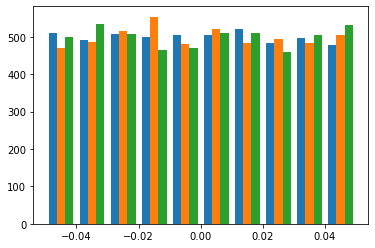

In [4]:
plt.hist(particles.x.transpose(0,1).to('cpu'))

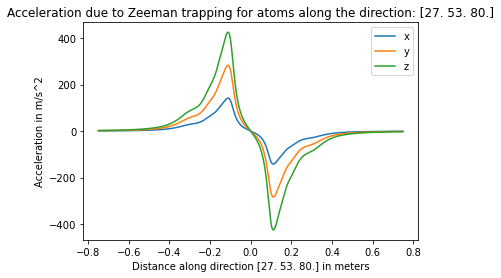

-10.913481972421202


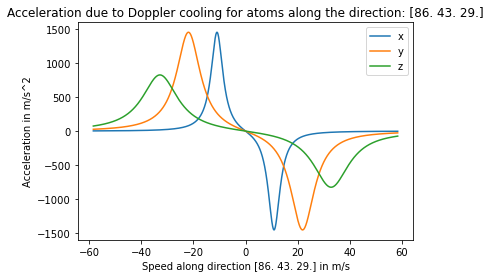

In [27]:
if False: #zeeman in x
    xsh,ysh,zsh=2000,1,1
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.3,0.3,xsh),t.linspace(-0.01,0.9,ysh),t.linspace(-0.01,0.5,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    Accel,_=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,xsh,endpoint=True),Accel[:,0,0,0].cpu().numpy())
    plt.show()
    
if False: #zeeman in y
    xsh,ysh,zsh=1,2000,1
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.01,0.9,xsh),t.linspace(-0.3,0.3,ysh),t.linspace(-0.01,0.5,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    Accel,_=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,ysh,endpoint=True),Accel[0,:,0,1].cpu().numpy())
    plt.show()
    
if False: #zeeman in z
    xsh,ysh,zsh=1,1,2000
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.01,0.0,xsh),t.linspace(-0.01,0.9,ysh),t.linspace(-0.3,0.3,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    Accel,_=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,zsh,endpoint=True),Accel[int(xsh/2),0,:,2].cpu().numpy())
    plt.show()
      
if False: #doppler in z
    xsh,ysh,zsh=5,5,2000
    vel=t.zeros((3,xsh,ysh,zsh))
    vel[0],vel[1],vel[2]=t.meshgrid(t.linspace(-25,25,xsh),t.linspace(-25,25,ysh),t.linspace(-25,25,zsh))
    vel=vel.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    pos=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    Accel,_=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(2)
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.5,0.5,zsh,endpoint=True),Accel[int(xsh/2),int(ysh/2),:,2].cpu().numpy())
    plt.show
    
if True: #zeeman along a given direction
    direction=0.20*np.array([1,2,3])
    num=100000
    d=np.linalg.norm(direction)
    pos=t.zeros((3,num))
    pos[0]=t.linspace(-direction[0],direction[0],num)
    pos[1]=t.linspace(-direction[1],direction[1],num)
    pos[2]=t.linspace(-direction[2],direction[2],num)
    pos=pos.transpose(0,1)
    vel=t.zeros((3,num)).transpose(0,1)
    particles.createbyinp(pos,vel,2,3)
    Accel,_=forward()
    A=Accel.cpu().numpy()
    plt.title('Acceleration due to Zeeman trapping for atoms along the direction: '+str(np.round(100*direction/d)))
    plt.plot(np.linspace(-d,d,num),A[:,0],label='x')
    plt.plot(np.linspace(-d,d,num),A[:,1],label='y')
    plt.plot(np.linspace(-d,d,num),A[:,2],label='z')
    plt.xlabel('Distance along direction ' +str(np.round(100*direction/d))+' in meters')
    plt.ylabel('Acceleration in m/s^2')
    plt.legend()
    plt.show()
    print(np.sum(A[int(num/2):,0]*d/num))
    
if True: #doppler along a given direction
    direction=50*np.array([1,1/2,1/3])
    d=np.linalg.norm(direction)
    num=5000
    vel=t.zeros((3,num))
    vel[0]=t.linspace(-direction[0],direction[0],num)
    vel[1]=t.linspace(-direction[1],direction[1],num)
    vel[2]=t.linspace(-direction[2],direction[2],num)
    vel=vel.transpose(0,1)
    pos=t.zeros((3,num)).transpose(0,1)
    particles.createbyinp(pos,vel,2,3)
    Accel,_=forward()
    A=Accel.cpu().numpy()
    plt.title('Acceleration due to Doppler cooling for atoms along the direction: '+str(np.round(100*direction/d)))
    plt.plot(np.linspace(-d,d,num),A[:,0],label='x')
    plt.plot(np.linspace(-d,d,num),A[:,1],label='y')
    plt.plot(np.linspace(-d,d,num),A[:,2],label='z')
    plt.xlabel('Speed along direction ' +str(np.round(100*direction/d))+' in m/s')
    plt.ylabel('Acceleration in m/s^2')
    plt.legend()
    plt.show()


In [16]:
Simlen=2000
x,v=particles.init_track(Simlen=Simlen)
tstep=0.0005
for i in tqdm(range (Simlen), desc="simulating"):
    _,_  =forward(timestep=tstep,acceladj=True,grav=True)
    x,v=particles.track(x,v,i)
print(v)




simulating: 100%|██████████| 2000/2000 [01:23<00:00, 23.90it/s]

tensor([[-7.2007e+00,  5.1908e-01,  3.9688e+00],
        [-7.0669e+00,  6.3999e-01,  3.8661e+00],
        [-6.9206e+00,  7.2985e-01,  3.7474e+00],
        ...,
        [ 1.8069e-07,  3.5511e-07, -1.5490e-06],
        [ 1.8069e-07,  3.5511e-07, -1.9639e-06],
        [ 1.8069e-07,  3.5511e-07, -2.3735e-06]], device='cuda:0')


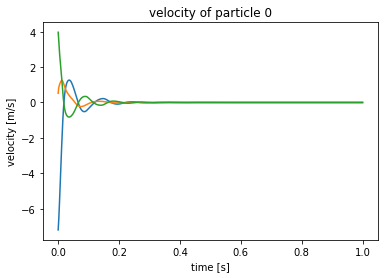

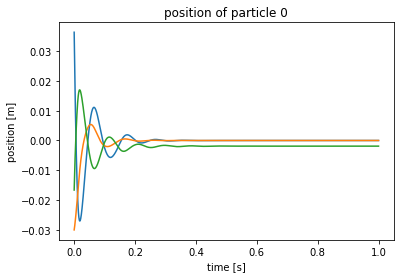

In [17]:
plt.plot(np.linspace(0,Simlen*tstep,Simlen+1), v[:,:].cpu().numpy())
plt.title('velocity of particle 0')
plt.xlabel("time [s]")
plt.ylabel("velocity [m/s]")
plt.show()
plt.plot(np.linspace(0,Simlen*tstep,Simlen+1),x[:,:].cpu().numpy())
plt.title('position of particle 0')
plt.xlabel("time [s]")
plt.ylabel("position [m]")
plt.show()

In [4]:
print(t.round(1000*t.norm(particles.v,dim=1)))
T=t.round(1000*t.norm(particles.v,dim=1))
k=0
for i in T:
    if i==0:
        k+=1
print(k)

AttributeError: type object 'particles' has no attribute 'v'

In [5]:
temps=[]
prop=[]
for Tinv in tqdm(range(1,400),desc="running simulations"):
    T=10/Tinv
    temps.append(T)
    particles.create(T=T)
    Simlen=100
    x,v=particles.init_track(Simlen=Simlen)
    tstep=0.01
    for i in range (Simlen):
        _,_  =forward(timestep=tstep,acceladj=True,grav=True)
        x,v=particles.track(x,v,i)
    s=t.round(1000*t.norm(particles.v,dim=1))
    k=0
    for i in s:
        if i==0:
            k+=1
    prop.append(k/5000)
    

    


running simulations: 100%|██████████| 399/399 [31:38<00:00,  4.76s/it]


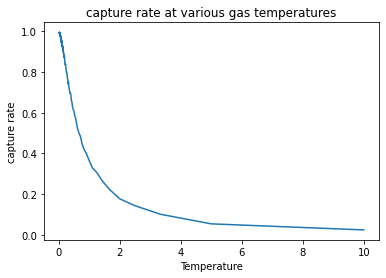

In [8]:
prop=np.array(prop)
plt.plot(temps,prop)
plt.xlabel("Temperature")
plt.ylabel("capture rate")
plt.title("capture rate at various gas temperatures")
plt.show()